# Do data scientists have fun their jobs?

Recently it is said data scientist is important for data-driven company management. A word of 'Data Scientist' itself is attracting the most attention now, but as a matter of fact, is data scientist increased? Do they satisfy with their jobs? or How much salary do they earn? I have mined data to answer the questions.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# magic word for producing visualizations in notebook
%matplotlib inline

## Business understanding

### Key Questions

1. How are data scientists increased from 2017 to 2018?
2. How is data scientist job satisfaction increased from 2017 to 2018?
3. How is data scientist annual salary increased from 2017 to 2018?

## Data understanding

I used [Stack Overflow Annual Developer Survey](https://insights.stackoverflow.com/survey), in paticuler for looking trend of data scientist, [2018 Survey Results](https://insights.stackoverflow.com/survey/2018) and [2017 Survey Results](https://insights.stackoverflow.com/survey/2017).

#### Orverview
- 2018: Total developer answering is 98,855, A number of question is 129.
- 2017: Total developer ansering is 51,392, A number of question is 154.

#### Note
- Database administrator is regarded as a control group.
    - Database administrator is related data as the same as data scientist
    - it compares values between two groups.
- Variables are selected to answer the key questions.
    - 2018: DevType, JobSatisfaction, Salary, SalaryType
    - 2017: DeveloperType, JobSatisfaction, Salary

In [2]:
# loading data as np.object.
df_2018_schema = pd.read_csv('data/developer_survey_2018/survey_results_schema.csv', dtype=np.object)
df_2018 = pd.read_csv('data/developer_survey_2018/survey_results_public.csv', dtype=np.object)

In [3]:
print("Year 2018, Total developer answering: {}, a number of question: {}".format(df_2018.shape[0], df_2018.shape[1]))

Year 2018, Total developer answering: 98855, a number of question: 129


In [4]:
# To answer key questions, these columns is used.
df_2018_schema[(df_2018_schema['Column'] == 'DevType') | (df_2018_schema['Column'] == 'JobSatisfaction') | (df_2018_schema['Column'] == 'Salary') | (df_2018_schema['Column'] == 'SalaryType')]

,Column,QuestionText
9,DevType,Which of the following describe you? Please se...
12,JobSatisfaction,How satisfied are you with your current job? I...
52,Salary,What is your current gross salary (before taxe...
53,SalaryType,"Is that salary weekly, monthly, or yearly?"


In [5]:
# loading data as np.object.
df_2017_schema = pd.read_csv('data/developer_survey_2017/survey_results_schema.csv', dtype=np.object)
df_2017 = pd.read_csv('data/developer_survey_2017/survey_results_public.csv', dtype=np.object)

In [6]:
print("Year 2017, Total developer answering: {}, a number of question: {}".format(df_2017.shape[0], df_2017.shape[1]))

Year 2017, Total developer answering: 51392, a number of question: 154


In [7]:
# To answer key questions, these columns is used.
df_2017_schema[(df_2017_schema['Column'] == 'DeveloperType') | (df_2017_schema['Column'] == 'JobSatisfaction') | (df_2017_schema['Column'] == 'Salary')]

,Column,Question
14,DeveloperType,Which of the following best describe you?
19,JobSatisfaction,Job satisfaction rating
152,Salary,"What is your current annual base salary, befor..."


## Data Preparation

Loading and preparing data.

### Data preparation for 2018 survey results

In [8]:
# Replace data frame that have required columns to answer the questions
df_2018 = df_2018[['DevType', 'JobSatisfaction', 'Salary', 'SalaryType']]
df_2018.head()

,DevType,JobSatisfaction,Salary,SalaryType
0,Full-stack developer,Extremely satisfied,NaN,Monthly
1,Database administrator;DevOps specialist;Full-...,Moderately dissatisfied,51000,Yearly
2,Engineering manager;Full-stack developer,Moderately satisfied,NaN,NaN
3,Full-stack developer,Neither satisfied nor dissatisfied,NaN,NaN
4,Data or business analyst;Desktop or enterprise...,Slightly satisfied,260000,Yearly


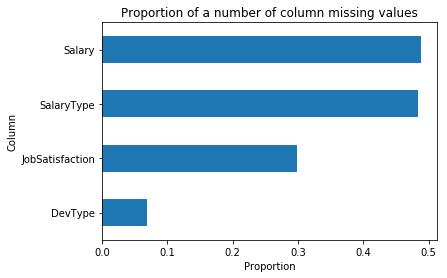

In [9]:
# Check a missing values
(df_2018.isnull().sum() / df_2018.shape[0]).sort_values().plot.barh(cmap='tab20')
plt.title('Proportion of a number of column missing values')
plt.xlabel('Proportion')
plt.ylabel('Column')
plt.show()

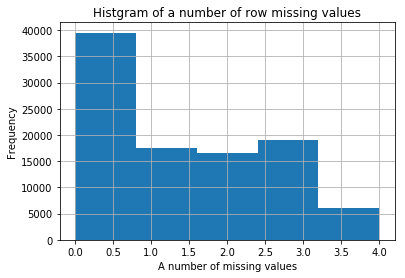

In [10]:
df_2018.isnull().sum(axis=1).hist(bins=5)
plt.title('Histgram of a number of row missing values')
plt.xlabel('A number of missing values')
plt.ylabel('Frequency')
plt.show()

#### Note: Missing values handled

Missing values are not handeld like removing or imputing values, because if missing values are removed or imputed, it makes bias that is provided by people to properly answers. So keeping values unchanged, I analyze this data only using non missing values of each columns.

In [11]:
# JobSatisfaction
# 
# Replace answer of string into integer that have average 0.5.
#
# First, replace string into integer
#     Extremely dissatisfied -> 0
#     Moderately dissatisfied -> 1
#     Slightly dissatisfied -> 2
#     Neither satisfied nor dissatisfied -> 3
#     Slightly satisfied -> 4
#     Moderately satisfied -> 5
#     Extremely satisfied
#
# Second, apply min-max scalering.
#     {JobSatisfaction} / (6 - 0)

df_2018['JobSatisfaction'] = df_2018['JobSatisfaction'].replace({
    'Extremely dissatisfied': 0,
    'Moderately dissatisfied': 1,
    'Slightly dissatisfied': 2,
    'Neither satisfied nor dissatisfied': 3,
    'Slightly satisfied': 4,
    'Moderately satisfied': 5,
    'Extremely satisfied': 6
}) / (6. - 0.)

In [12]:
# Convert salary to discuss by annual salary
#
# if SalaryType is Monthly then Salary * 12
# if Salarytype is Weekly then Salary * 4 * 12

converted_salary = []
for salary, salary_type in zip(df_2018['Salary'].values, df_2018['SalaryType'].values):
    salary = np.float(np.str(salary).replace(',', ''))

    if salary_type == 'Monthly':
        salary = salary * 12
    elif salary_type == 'Weekly':
        salary = salary * 4 * 12

    converted_salary.append(salary)

df_2018['Salary'] = pd.Series(converted_salary)
df_2018.drop('SalaryType', axis=1, inplace=True)

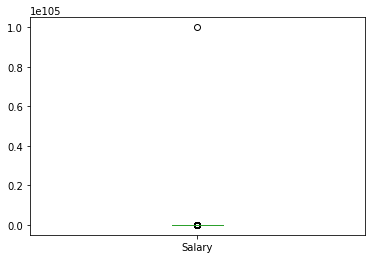

In [13]:
# Check box plot
df_2018['Salary'].plot(kind='box')
plt.show()

In [14]:
# Remove outlier
#
# Outline:
#     1. Convert value to log
#     2. Remove outlier by using IRQ

df_2018_salary_log = np.log(df_2018['Salary'] + 1.)

q1 = df_2018_salary_log.describe()['25%']
q2 = df_2018_salary_log.describe()['50%']
q3 = df_2018_salary_log.describe()['75%']

irq = q3 - q1

converted_salary = []
for salary, log_salary in zip(df_2018['Salary'].values, df_2018_salary_log.values):
    if log_salary < q2 - 1.5 * irq:
        converted_salary.append(np.nan)
    elif log_salary > q2 + 1.5 * irq:
        converted_salary.append(np.nan)
    else:
        converted_salary.append(salary)

df_2018['Salary'] = pd.Series(converted_salary)

In [15]:
df_2018.head()

,DevType,JobSatisfaction,Salary
0,Full-stack developer,1.000000,NaN
1,Database administrator;DevOps specialist;Full-...,0.166667,51000.0
2,Engineering manager;Full-stack developer,0.833333,NaN
3,Full-stack developer,0.500000,NaN
4,Data or business analyst;Desktop or enterprise...,0.666667,260000.0


In [16]:
df_2018.shape

(98855, 3)

### Data preparation for 2017 survey results

In [17]:
# Replace data frame that have required columns to answer the questions
df_2017 = df_2017[['DeveloperType', 'JobSatisfaction', 'Salary']]
df_2017.head()

,DeveloperType,JobSatisfaction,Salary
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Other,9,113750
3,NaN,3,NaN
4,Mobile developer; Graphics programming; Deskto...,8,NaN


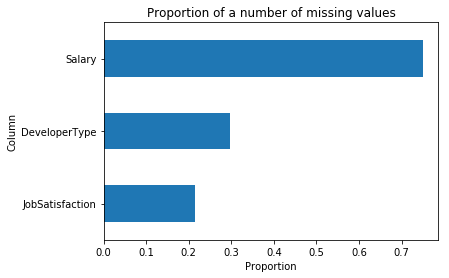

In [18]:
# Check a missing values
(df_2017.isnull().sum() / df_2017.shape[0]).sort_values().plot.barh(cmap='tab20')
plt.title('Proportion of a number of missing values')
plt.xlabel('Proportion')
plt.ylabel('Column')
plt.show()

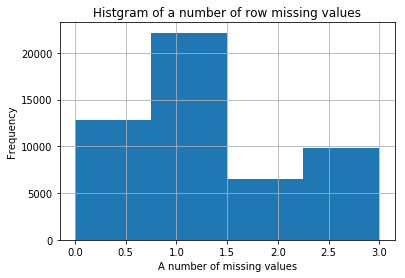

In [19]:
df_2017.isnull().sum(axis=1).hist(bins=4)
plt.title('Histgram of a number of row missing values')
plt.xlabel('A number of missing values')
plt.ylabel('Frequency')
plt.show()

#### Note: Missing values handled

Missing values are not handeld like removing or imputing values, because if missing values are removed or imputed, it makes bias that is provided by people to properly answers. So keeping values unchanged, I analyze this data only using non missing values of each columns.

In [20]:
# JobSatisfaction
# 
# Replace answer of string into integer that have average 0.5.
#
# Apply min-max scalering.
#     {JobSatisfaction} / (10. - 0.)
df_2017['JobSatisfaction'] = df_2017['JobSatisfaction'].astype(float) / (10. - 0.)

In [21]:
converted_salary = []
for salary in df_2017['Salary'].values:
    salary = np.float(np.str(salary).replace(',', ''))
    converted_salary.append(salary)
    
df_2017['Salary'] = pd.Series(converted_salary)

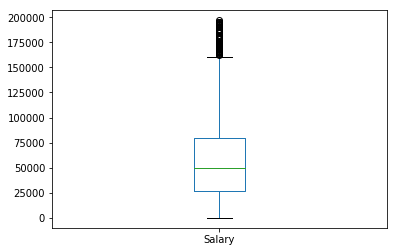

In [22]:
# Check box plot
df_2017['Salary'].plot(kind='box')
plt.show()

In [23]:
# Remove outlier
#
# Outline:
#     1. Convert value to log
#     2. Remove outlier by using IRQ

df_2017_salary_log = np.log(df_2017['Salary'] + 1.)

q1 = df_2017_salary_log.describe()['25%']
q2 = df_2017_salary_log.describe()['50%']
q3 = df_2017_salary_log.describe()['75%']

irq = q3 - q1

converted_salary = []
for salary, log_salary in zip(df_2017['Salary'].values, df_2017_salary_log.values):
    if log_salary < q2 - 1.5 * irq:
        converted_salary.append(np.nan)
    elif log_salary > q2 + 1.5 * irq:
        converted_salary.append(np.nan)
    else:
        converted_salary.append(salary)

df_2017['Salary'] = pd.Series(converted_salary)

In [24]:
df_2017.head()

,DeveloperType,JobSatisfaction,Salary
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,Other,0.9,113750.0
3,NaN,0.3,NaN
4,Mobile developer; Graphics programming; Deskto...,0.8,NaN


In [25]:
df_2017.shape

(51392, 3)

## Evaluation

### Question 1: How are data scientist increased from 2017 to 2018?

#### Answer

Data Scientist proportion is increased from 2017 to 2018.
- Proportion: 2017 has 7.0 %, 2018 has 7.2 %
- Difference of proportion from 2017 to 2018: +0.2 %

Checking atabase administrator proportion as a comparison.
- Proportion: 2017 has 10.1 %, 2018 has 13.4 %
- Difference of proportion from 2017 to 2018: +3.3 %

Data Scientist is incresed from 2017 to 2018. However, comparing with Database administrator, increase amount is small.

In [26]:
data_scientist_2018 = []
database_administrator_2018 = []

for answers in df_2018['DevType'].astype(str).str.split(';'):
    answers = [a.strip() for a in answers]
    
    if 'Data scientist or machine learning specialist' in answers:
        data_scientist_2018.append(True)
    else:
        data_scientist_2018.append(False)

    if 'Database administrator' in answers:
        database_administrator_2018.append(True)
    else:
        database_administrator_2018.append(False)

print("Data scientist or machine learning specialist: {}, account for {:.1f} %".format(
    df_2018[data_scientist_2018].shape[0],
    df_2018[data_scientist_2018].shape[0] / df_2018.shape[0] * 100
))

print("Database administrator: {}, account for {:.1f} %".format(
    df_2018[database_administrator_2018].shape[0],
    df_2018[database_administrator_2018].shape[0] / df_2018.shape[0] * 100
))

Data scientist or machine learning specialist: 7088, account for 7.2 %
Database administrator: 13216, account for 13.4 %


In [27]:
data_scientist_2017 = []
database_administrator_2017 = []

for answers in df_2017['DeveloperType'].astype(str).str.split(';'):
    answers = [a.strip() for a in answers]
    
    if 'Data scientist' in answers or 'Machine learning specialist' in answers:
        data_scientist_2017.append(True)
    else:
        data_scientist_2017.append(False)

    if 'Database administrator' in answers:
        database_administrator_2017.append(True)
    else:
        database_administrator_2017.append(False)

print("Data scientist or machine learning specialist: {}, account for {:.1f} %".format(
    df_2017[data_scientist_2017].shape[0],
    df_2017[data_scientist_2017].shape[0] / df_2017.shape[0] * 100
))

print("Others: {}, account for {:.1f} %".format(
    df_2017[database_administrator_2017].shape[0],
    df_2017[database_administrator_2017].shape[0] / df_2017.shape[0] * 100
))

Data scientist or machine learning specialist: 3595, account for 7.0 %
Others: 5192, account for 10.1 %


In [28]:
proportion = pd.DataFrame({
    'Data scientist or Machine learning specialist': [
        df_2017[data_scientist_2017].shape[0] / df_2017.shape[0] * 100,
        df_2018[data_scientist_2018].shape[0] / df_2018.shape[0] * 100
    ],
    'Database administrator': [
        df_2017[database_administrator_2017].shape[0] / df_2017.shape[0] * 100,
        df_2018[database_administrator_2018].shape[0] / df_2018.shape[0] * 100
    ]
})

proportion_diff = pd.DataFrame({
    'Difference': [
         df_2018[database_administrator_2018].shape[0] / df_2018.shape[0] * 100
            -df_2017[database_administrator_2017].shape[0] / df_2017.shape[0] * 100,
        df_2018[data_scientist_2018].shape[0] / df_2018.shape[0] * 100
            -df_2017[data_scientist_2017].shape[0] / df_2017.shape[0] * 100
    ]
})

proportion.index = ['2017', '2018']
proportion_diff.index = ['Database administrator', 'Data scientist\nor Machine learning specialist']

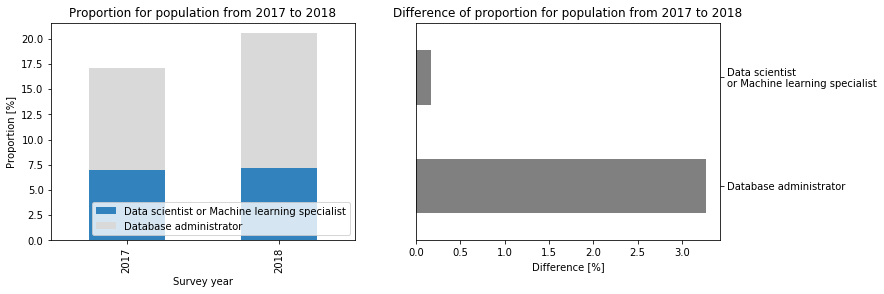

In [29]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust()

ax1 = plt.subplot(1, 2, 1)
proportion.plot.bar(stacked=True, cmap='tab20c', ax=ax1)
plt.legend(loc='lower right')
plt.title('Proportion for population from 2017 to 2018')
plt.xlabel('Survey year')
plt.ylabel('Proportion [%]')

ax2 = plt.subplot(1, 2, 2)
ax2.yaxis.tick_right()
proportion_diff.plot.barh(legend=False, color='grey', ax=ax2)
plt.title('Difference of proportion for population from 2017 to 2018')
plt.xlabel('Difference [%]')

plt.show()

### Question 2: How is data scientist job satisfaction increased from 2017 to 2018?

#### Answer

Data Scientist job satisfaction is increased from 2017 to 2018. Note: job satisfaction is scaled from 0.0 (min) to 1.0 (max).
- Median of job satisfaction: 2017 has 0.80, 2018 has 0.83
- Difference of median of job satisfaction from 2017 to 2018: +0.03

Checking for database administrator satisfaction as a comparison.
- Median of job satisfaction: 2017 has 0.70, 2018 has 0.83
- Difference of median of job satisfaction from 2017 to 2018: +0.13

Data Scientist satisfaction is incresed from 2017 to 2018. However, comparing with database administrator, increase amount is small. In particular, data scientist satisfaction was 0.8 at 2017 and database administrator job satisfaction was 0.7 at 2017. But both satisfaction are 0.83 at 2018. So there is no difference about satisfaction between two at 2018.

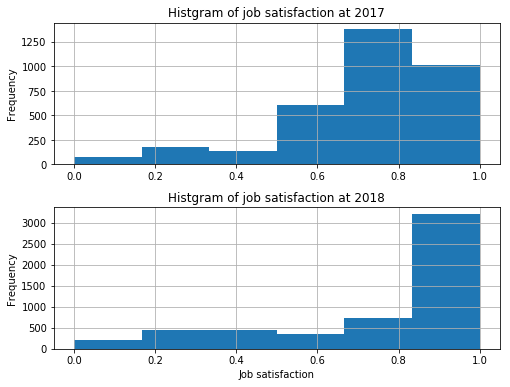

In [30]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax = plt.subplot(2, 1, 1)
df_2017[data_scientist_2017]['JobSatisfaction'].hist(bins=6)
plt.title('Histgram of job satisfaction at 2017')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2, sharex=ax)
df_2018[data_scientist_2018]['JobSatisfaction'].hist(bins=6)
plt.title('Histgram of job satisfaction at 2018')
plt.xlabel('Job satisfaction')
plt.ylabel('Frequency')

plt.show()

In [31]:
# Show median values
print("Data scientist median of satisfaction at 2017: {:.4f}".format(df_2017[data_scientist_2017]['JobSatisfaction'].median()))
print("Data scientist median of satisfaction at 2018: {:.4f}".format(df_2018[data_scientist_2018]['JobSatisfaction'].median()))

Data scientist median of satisfaction at 2017: 0.8000
Data scientist median of satisfaction at 2018: 0.8333


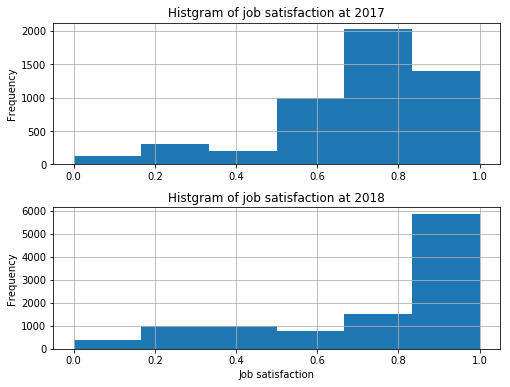

In [32]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax = plt.subplot(2, 1, 1)
df_2017[database_administrator_2017]['JobSatisfaction'].hist(bins=6)
plt.title('Histgram of job satisfaction at 2017')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2, sharex=ax)
df_2018[database_administrator_2018]['JobSatisfaction'].hist(bins=6)
plt.title('Histgram of job satisfaction at 2018')
plt.xlabel('Job satisfaction')
plt.ylabel('Frequency')

plt.show()

In [33]:
# Show median values
print("Database administrator median of satisfaction at 2017: {:.4f}".format(df_2017[database_administrator_2017]['JobSatisfaction'].median()))
print("Database administrator median of satisfaction at 2018: {:.4f}".format(df_2018[database_administrator_2018]['JobSatisfaction'].median()))

Database administrator median of satisfaction at 2017: 0.7000
Database administrator median of satisfaction at 2018: 0.8333


In [34]:
satisfaction = pd.DataFrame({
    'Data scientist or Machine learning specialist': [
        df_2017[data_scientist_2017]['JobSatisfaction'].median(),
        df_2018[data_scientist_2018]['JobSatisfaction'].median()
    ],
    'Database administrator': [
        df_2017[database_administrator_2017]['JobSatisfaction'].median(),
        df_2018[database_administrator_2018]['JobSatisfaction'].median()
    ]
})

satisfaction_diff = pd.DataFrame({
    'Difference': [
        df_2018[database_administrator_2018]['JobSatisfaction'].median()
            - df_2017[database_administrator_2017]['JobSatisfaction'].median(),
        df_2018[data_scientist_2018]['JobSatisfaction'].median()
            - df_2017[data_scientist_2017]['JobSatisfaction'].median()
    ]
})

satisfaction.index = ['2017', '2018']
satisfaction_diff.index = ['Database administrator', 'Data scientist\nor Machine learning specialist']

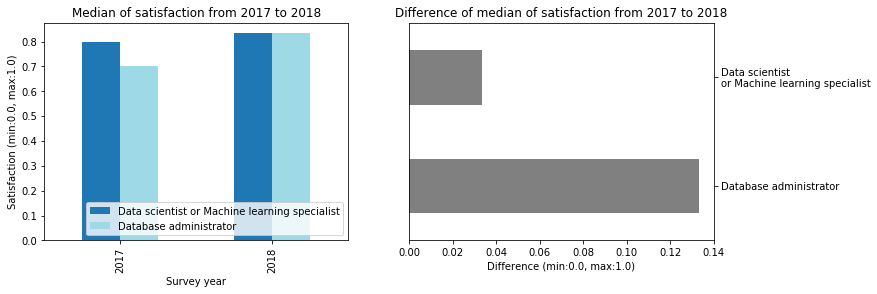

In [35]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust()

ax1 = plt.subplot(1, 2, 1)
satisfaction.plot.bar(cmap='tab20', ax=ax1)
plt.legend(loc='lower right')
plt.title('Median of satisfaction from 2017 to 2018')
plt.xlabel('Survey year')
plt.ylabel('Satisfaction (min:0.0, max:1.0)')

ax2 = plt.subplot(1, 2, 2)
ax2.yaxis.tick_right()
satisfaction_diff.plot.barh(legend=False, color='grey', ax=ax2)
plt.title('Difference of median of satisfaction from 2017 to 2018')
plt.xlabel('Difference (min:0.0, max:1.0)')

plt.show()

### Question 3: How are difference data scientist and database administrator salary at 2018?

#### Answer

Data Scientist annual salary is increased from 2017 to 2018.
- Median of job satisfaction: 2017 has 60000, 2018 has 78300
- Difference of median of job satisfaction from 2017 to 2018: +18300

Checking for atabase administrator annual salary as a comparison.
- Median of job satisfaction: 2017 has 53763, 2018 has 70000
- Difference of median of job satisfaction from 2017 to 2018: +16237

Data Scientist salary is incresed from 2017 to 2018. In addition, comparing with database administrator salary, increase amount is larger. So data scientist salary at each years is greater than database administrator salary.

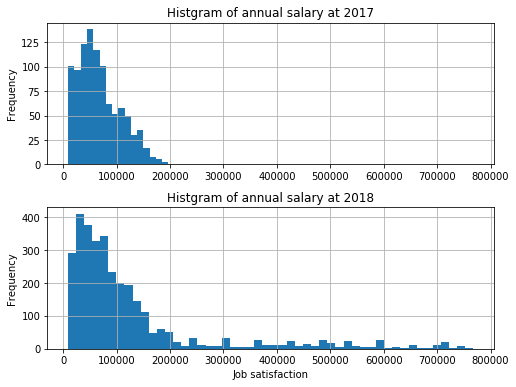

In [36]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax = plt.subplot(2, 1, 1)
df_2017[data_scientist_2017]['Salary'].hist(bins=16)
plt.title('Histgram of annual salary at 2017')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2, sharex=ax)
df_2018[data_scientist_2018]['Salary'].hist(bins=50)
plt.title('Histgram of annual salary at 2018')
plt.xlabel('Job satisfaction')
plt.ylabel('Frequency')

plt.show()

In [37]:
# Show median values
print("Data scientist median of salary at 2017: {:.4f}".format(df_2017[data_scientist_2017]['Salary'].median()))
print("Data scientist median of salary at 2018: {:.4f}".format(df_2018[data_scientist_2018]['Salary'].median()))

Data scientist median of salary at 2017: 60000.0000
Data scientist median of salary at 2018: 78300.0000


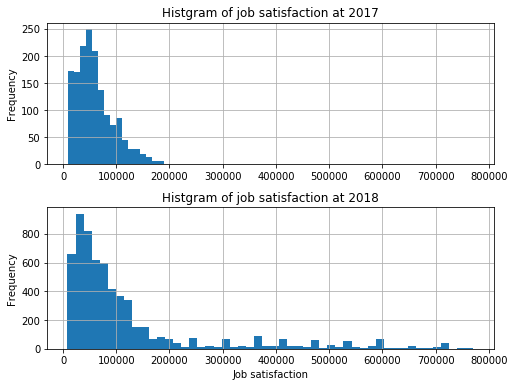

In [38]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.3)

ax = plt.subplot(2, 1, 1)
df_2017[database_administrator_2017]['Salary'].hist(bins=16)
plt.title('Histgram of job satisfaction at 2017')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2, sharex=ax)
df_2018[database_administrator_2018]['Salary'].hist(bins=50)
plt.title('Histgram of job satisfaction at 2018')
plt.xlabel('Job satisfaction')
plt.ylabel('Frequency')

plt.show()

In [39]:
# Show median values
print("Database administrator median of satisfaction at 2017: {:.4f}".format(df_2017[database_administrator_2017]['Salary'].median()))
print("Database administrator median of satisfaction at 2018: {:.4f}".format(df_2018[database_administrator_2018]['Salary'].median()))

Database administrator median of satisfaction at 2017: 53763.4409
Database administrator median of satisfaction at 2018: 70000.0000


In [40]:
salary = pd.DataFrame({
     'Data scientist or Machine learning specialist': [
        df_2017[data_scientist_2017]['Salary'].median(),
        df_2018[data_scientist_2018]['Salary'].median()
    ],
    'Database administrator': [
        df_2017[database_administrator_2017]['Salary'].median(),
        df_2018[database_administrator_2018]['Salary'].median()
    ]
})

salary_diff = pd.DataFrame({
    'Difference': [
        df_2018[database_administrator_2018]['Salary'].median()
            - df_2017[database_administrator_2017]['Salary'].median(),
        df_2018[data_scientist_2018]['Salary'].median()
            - df_2017[data_scientist_2017]['Salary'].median()
    ]
})

salary.index = ['2017', '2018']
salary_diff.index = ['Database administrator', 'Data scientist\nor Machine learning specialist']

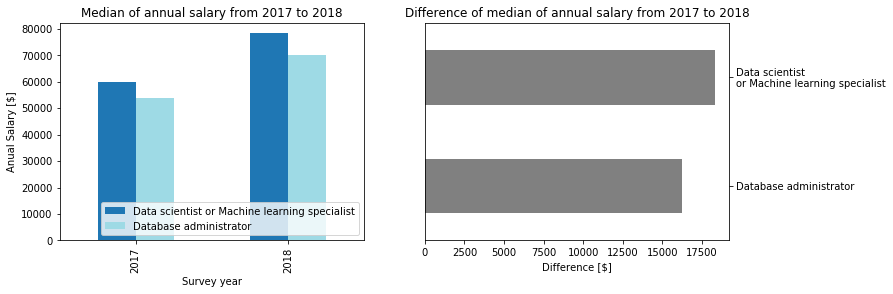

In [41]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust()

ax1 = plt.subplot(1, 2, 1)
salary.plot.bar(cmap='tab20', ax=ax1)
plt.legend(loc='lower right')
plt.title('Median of annual salary from 2017 to 2018')
plt.xlabel('Survey year')
plt.ylabel('Anual Salary [$]')

ax2 = plt.subplot(1, 2, 2)
ax2.yaxis.tick_right()
salary_diff.plot.barh(legend=False, color='grey', ax=ax2)
plt.title('Difference of median of annual salary from 2017 to 2018')
plt.xlabel('Difference [$]')

plt.show()

## Conclusion

As a result, just because it is said data scientist is important, specific improvement for environment surrounding them is not seen from 2017 to 2018. Even though annual salary of data scientist is greater than the salary of database administrator, actually improvement for database administrator job satisfaction is greater than data scientist job satisfaction.

Looking at database administrator proportion and job satisfaction, it is better to become database administrator. Because a number of the developers is more increased (maybe it is that demand for them is also increased) and their satisfaction is also high as the same as data scientist. But I want to be great data scientist because I like gradient boosting, monte carlo simulation or money!

## Appendix

In addition, I applied salary of two at 2018 to significant test by using Mann-Whitney U test. As a result, the difference between data scientist median of salary at 2018 (78300) and database administrator median of salary (70000) is significant under significance level of 5%.

In [42]:
def significant_test(df_1, df_2, column):
    """Significant test using Mann-Whiteney U.
    
    Args:
        df_1: pd.Series, first data that is provided to x in stats.mannwhitneyu.
        df_2: pd.Series, second data that is provided to y in stats.mannwhitneyu.

    Retruns:
        None
    """
    x = df_1[~df_1[column].isnull()][column]
    y = df_2[~df_2[column].isnull()][column]

    satistic, pvalue = stats.mannwhitneyu(x, y, alternative='two-sided')

    print("Mann-Whitney U test")
    print("---------------------------------------------------------------------------")
    print("Data scineintist median of salary: {:.1f}".format(x.median()))
    print("Database administrator median of salary: {:.1f}".format(y.median()))
    print("---------------------------------------------------------------------------")
    print("P-value: {:.4f}".format(pvalue))

    if pvalue <= 0.05:
        significant = True
    else:
        significant = False

    print("Statistical significant is " + str(significant) + " under significance level of 5%")

In [43]:
significant_test(df_2018[data_scientist_2018], df_2018[database_administrator_2018], 'Salary')

Mann-Whitney U test
---------------------------------------------------------------------------
Data scineintist median of salary: 78300.0
Database administrator median of salary: 70000.0
---------------------------------------------------------------------------
P-value: 0.0000
Statistical significant is True under significance level of 5%
